# <center>Probabilistic Programming Workflow</center>

## <center>Open Source Tools for Open Science</center>

### Open Source Tools for Open Science:


* Fully Replicable Modeling Pipeline
    * Data preprocessing
    * Model fitting
    * Model evaluation


* Transparent Model Building
    * explicit (i.e. debatable) assumptions
    * criticizable models
 
* Probabilistic Programming

<a id=TOP /></a>
Probabilistic Programming

1. [A Quick Primer](#primer)
2. [Approximating the Data Generation Process](#pymc3)
3. [Prior Simulation and Iterative Model Development](#priors)
4. [Fitting Data, Model Evaluation, Model Comparison](#fiteval)
5. [Conclusion](#conclusion)

[Back to Contents](#TOP)

<a id=primer /></a>
### A. A Quick Primer
<br><br>

Joint Probability:
$$P(A,B) = P(A|B) \times P(B) = P(B|A) \times P(B)$$

Yields Bayes Theorem:
$$P(A|B) = \frac{P(B|A)\times P(B)}{P(A)}$$

From Bayes to Probabilistic Programming:


<br>$\ \ \ \rightarrow$ Goal approximate the process that generates observations of interest
<br>$\ \ \ \rightarrow$ postulate model(s, preferably)
<br>$\ \ \ \rightarrow$ include background knowledge: priors on model parameters, $H$
<br>$\ \ \ \rightarrow$ collect observation; $D$
<br>$\ \ \ \rightarrow$ use probabilistic sampling to find likeliest values of $H$:
$$P(H|D) = \frac{P(D|H)P(H)}{P(D)}$$<br>

In practice: 
$$P(H|D) \propto P(D|H)P(H)$$

* P(H): prior on H $\Rightarrow$ quantify of background information
* P(D|H): likelihood of D given H
* P(H|D): probability of H given D $\Rightarrow$ what we're after
* Fitting is done by sampling rather than optimization

[Back to Contents](#TOP)

<a id=pymc3 ></a>
Probabilistic Programming
    
1. ~~A Quick Primer~~
2. <font color=red>Approximating the Data Generation Process</font>
3. Prior Simulation and Iterative Model Development
4. Fitting Data, Model Evaluation, Model Comparison
5. Conclusion

In [1]:
import pickle # binary storage library

import numpy as np # linear algebra library
from scipy.stats import norm # stats library
import pandas as pd # data manipulation library

import pymc3 as pm # Probabilistic Programming (PP) library

import arviz as ar # PP visualization library
import matplotlib.pyplot as pl # graphic library
import seaborn as sb # # statistical graph library

In [14]:
from matplotlib import rcParams

In [2]:
# NOTEBOOK-WIDE Graphical settings
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [3]:
with open('./preprocess_dicts.pkl', 'rb') as fb:
    preproc_dict = pickle.load(fb)

In [4]:
X_train_s = preproc_dict['training']['X_s']
X_test_s = preproc_dict['testing']['X_s']
y_train_s = preproc_dict['training']['y_s']
y_test_s = preproc_dict['testing']['y_s']

In [5]:
X_train_s.head()

,datetime,maxBlueID,maxBlueIdx,green2MaxBlue_s
216,1999-01-29 14:33:00,Rrs490,1,0.203137
242,2000-08-22 14:30:00,Rrs510,2,0.987330
278,1999-10-25 13:20:00,Rrs510,2,1.670619
141,1999-07-07 14:35:00,Rrs443,0,-1.018703
221,2001-06-04 19:11:00,Rrs490,1,0.065273


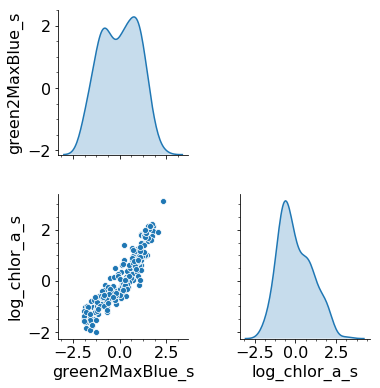

In [62]:
d_train_s = pd.merge(X_train_s, y_train_s, how='outer', left_index=True, right_index=True)
g = sb.pairplot(d_train_s, vars=['green2MaxBlue_s', 'log_chlor_a_s'], diag_kind='kde',
           );
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
f = pl.gcf()
f.set_figheight(6)
f.set_figwidth(6)
f.savefig('./resources/pairplot_pooled.png', dpi=300)

<img src='./resources/pairplot_pooled.png?:1' width=500 />

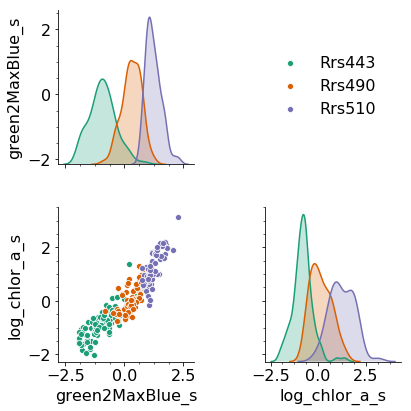

In [60]:
g = sb.pairplot(d_train_s, vars=['green2MaxBlue_s', 'log_chlor_a_s'], hue='maxBlueID',
            hue_order=['Rrs443', 'Rrs490', 'Rrs510'], palette='Dark2');
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.set_visible(False)
g.fig.legend(handles=handles, labels=labels, loc=(0.65, 0.7), frameon=False)
f = pl.gcf()
f.set_figheight(6)
f.set_figwidth(6)
f.tight_layout()
f.savefig('./resources/pairplot_grouped.png', dpi=300)

In [61]:
with pm.Model() as m_pooled_naive:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 5) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + X_train_s.green2MaxBlue_s.values * β # likelihood's mean deterministic model
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) # likelihood

In [29]:
m_pooled_naive_graph = pm.model_to_graphviz(m_pooled_naive)
m_pooled_naive_graph.format='png'
m_pooled_naive_graph.render(filename='m_pooled_naive_graph', directory='./resources/', view=False);

<center><img src='./resources/m_pooled_naive_graph.png?:1' width=700 /></center>

[Back to Contents](#TOP)

<a id=priors ></a>
Probabilistic Programming

1. ~~A Quick Primer~~
2. ~~Approximating the Data Generation Process~~
3. <font color=red>Prior Simulation and Iterative Model Development</font>
4. Pooled, Unpooled, Partially Pooled
4. Fitting Data, Model Evaluation, Model Comparison
5. Conclusion

In [9]:
def eval_priors(model, y_, fpath, ylim=(-5, 5)):
    # Sample parameters and simulate predictor from model priors
    # Sample parameters
    priors = pm.sample_prior_predictive(model=model, vars=['α', 'β', 'log_chl_s'])
    β_prior = priors['β'].reshape(-1, 1)
    α_prior = priors['α'].reshape(-1, 1)
    log_chl_prior = priors['log_chl_s']
    
    # Create dummy variable
    x_dummy = np.linspace(-3., 3., num=50).reshape(1, -1)
    # Simulate log chl from model priors
    log_chl_lines = α_prior + β_prior * x_dummy
    f, ax = pl.subplots(ncols=2, figsize=(12, 4))
    for i in range(500):
        ax[0].plot(x_dummy.T, log_chl_lines[i], alpha=0.03, color='k')
    ax[0].set_ylim(ylim);
    ax[0]. set_xlabel(r'$\frac{Rrs_{555}}{max(Rrs_{443}, Rrs_{490}, Rrs_{510})}$, standardized')
    ax[0].set_ylabel(r'$log_{10}(chl)$, standardized')
    ax[1].hist(priors['log_chl_s'].flatten(), density=True, alpha=0.3, bins=100,
               orientation='horizontal', label='prior');
    ax[1].set_ylim(ylim)
    ax[1].set_xticklabels([])
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position("right")
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel(r'$log_{10}(chl)$, standardized')
    ax[1].set_xlabel(r'$Freq.$')
    ax2 = ax[1].twiny()
    ax2.hist(y_.values, color='k', density=True, alpha=0.5, bins=20,
             orientation='horizontal', label='observed');
    ax2.set_xticklabels([])
    ax2.legend(loc='lower right')
    f.tight_layout()
    f.savefig(fpath, dpi=300)

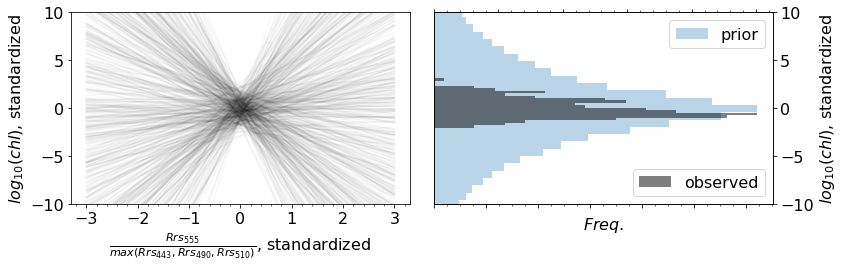

In [114]:
eval_priors(m_pooled_naive, y_=y_train_s.log_chlor_a_s, 
            fpath='./resources/priors_predictive_pooled_naive.png', ylim=(-10, 10))

<center><img src='./resources/priors_predictive_pooled_naive.png?:0'/></center>

$\Rightarrow$ Nonsensical log(chl) values $\rightarrow$ Priors too naive; need adjustment<br>
$\Rightarrow$ Informative priors $\rightarrow$ Incorportation of background knowledge into model

In [10]:
with pm.Model() as m_pooled_wk_informative:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 1) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + X_train_s.green2MaxBlue_s.values * β # likelihood's mean deterministic model
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) # likelihood

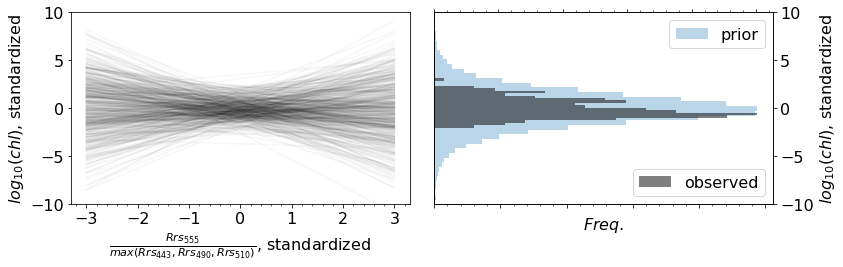

In [118]:
eval_priors(m_pooled_wk_informative, y_=y_train_s.log_chlor_a_s,
            fpath='./resources/priors_predictive_pooled_wk_informative.png', ylim=(-10, 10))

<center><img src='./resources/priors_predictive_pooled_wk_informative.png?:2'></center>

In [21]:
with pm.Model() as m_pooled_informative:
    α = pm.Normal('α', 0, 0.5) # prior on intercept
    β = pm.Normal('β', 0, 0.2) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + β * X_train_s.green2MaxBlue_s.values # likelihood's mean deterministic model
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) # likelihood

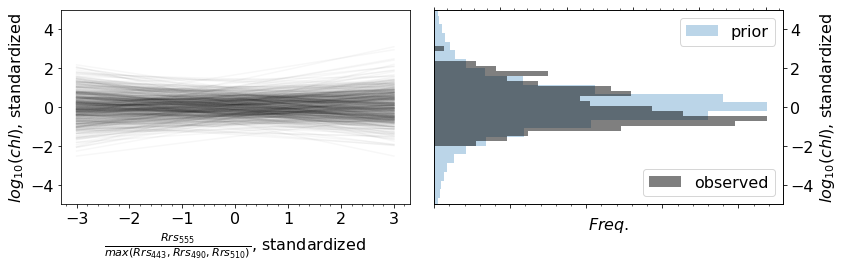

In [120]:
eval_priors(m_pooled_informative, y_=y_train_s.log_chlor_a_s,
            fpath='./resources/priors_predictive_pooled_informative.png', ylim=(-5, 5))

<center><img src='./resources/priors_predictive_pooled_informative.png?:3'/></center>

<a id=priors ></a>
Probabilistic Programming

1. ~~A Quick Primer~~
2. ~~Approximating the Data Generation Process~~
3. ~~Prior Simulation and Iterative Model Development~~
4. <font color=red>Pooled, Unpooled, Partially Pooled</font>
4. Fitting Data, Model Evaluation, Model Comparison
5. Conclusion

In [5]:
X_train_s.head()

,datetime,maxBlueID,maxBlueIdx,green2MaxBlue_s
216,1999-01-29 14:33:00,Rrs490,1,0.203137
242,2000-08-22 14:30:00,Rrs510,2,0.987330
278,1999-10-25 13:20:00,Rrs510,2,1.670619
141,1999-07-07 14:35:00,Rrs443,0,-1.018703
221,2001-06-04 19:11:00,Rrs490,1,0.065273


<table>
    <td>
        <img src='./resources/pairplot_pooled.png?:3' width=400/>
    </td>
    <td>
        <img src='./resources/pairplot_grouped.png?:2' width=400/>
    </td>
</table>    

In [18]:
n_blue_groups = X_train_s.maxBlueIdx.unique().size
with pm.Model() as m_unpooled_informative:
    # prior on intercept
    α = pm.Normal('α', 0, 0.5, shape=n_blue_groups) 
    # prior on slopes
    β = pm.Normal('β', 0, 0.2, shape=n_blue_groups) 
    # prior on likelihood variance
    σ = pm.Exponential('σ', 1) 
    # likelihood's mean deterministic expression
    μ = α[X_train_s.maxBlueIdx.values,] + (β[X_train_s.maxBlueIdx.values]
                                           * X_train_s.green2MaxBlue_s.values )
    # likelihood
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ,
                          observed=y_train_s.log_chlor_a_s.values) 

In [30]:
m_unpooled_informative_graph = pm.model_to_graphviz(m_unpooled_informative)
m_unpooled_informative_graph.format='png'
m_unpooled_informative_graph.render(filename='m_unpooled_informative_graph',
                                    directory='./resources/',
                                    view=False);

#### Pooled model:

<center><img src='./resources/m_pooled_naive_graph.png?:1' width=600 /></center>

#### Unpooled model:
<center><img src='./resources/m_unpooled_informative_graph.png?:0' width=600 /></center>

In [19]:
with pm.Model() as m_partially_pooled_informative:
    # prior on intercept
    hyp_α_mean = pm.Normal('hyp_α_mean', mu=0, sd=0.5)
    hyp_α_sd = pm.HalfCauchy('hyp_α_sd', beta=2.5)
    hyp_β_mean = pm.Normal('hyp_β_mean', mu=0, sd=0.2)
    hyp_β_sd = pm.HalfCauchy('hyp_β_sd', beta=2.5)
    # Here, I use an offsetting trick for easiser exploration of the parameter space
    #α_offset = pm.Normal('α_offset', mu=0, sd=1, shape=n_blue_groups)
    #β_offset = pm.Normal('β_offset', mu=0, sd=1, shape=n_blue_groups)
    # prior on intercepts
    α = pm.Normal('α', mu=hyp_α_mean, sd=hyp_α_sd, shape=n_blue_groups) 
    # prior on slopes
    β = pm.Normal('β', mu=hyp_β_mean, sd=hyp_β_sd, shape=n_blue_groups)
    # prior on likelihood variance
    σ = pm.Exponential('σ', 1) 
    # likelihood's mean deterministic expression
    μ = α[X_train_s.maxBlueIdx.values] + β[X_train_s.maxBlueIdx.values] * X_train_s.green2MaxBlue_s.values 
    # likelihood
    log_chl_s = pm.Normal('log_chl_s', mu=μ, sd=σ, observed=y_train_s.log_chlor_a_s.values) 

In [24]:
m_partially_pooled_informative_graph = pm.model_to_graphviz(m_partially_pooled_informative)
m_partially_pooled_informative_graph.format='png'
m_partially_pooled_informative_graph.render(filename='m_part_pooled_informative_graph',
                                    directory='./resources/',
                                    view=False);

#### Partially pooled model:
<br>
<center><img src='./resources/m_part_pooled_informative_graph.png?:0' width=1500 /></center>

<a id=overview></a>
Probabilistic Programming

1. ~~A Quick Primer~~
2. ~~Model Development: Approximating the Data Generating Process~~
3. ~~Prior Simulation and Iterative Model Development~~
4. ~~Pooled, Unpooled, Partially Pooled~~
5. <font color=red>Fitting Data, Model Evaluation, Model Comparison</font>
6. Conclusion

In [22]:
with m_pooled_informative:
    trace_pooled_informative = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1471.44draws/s]


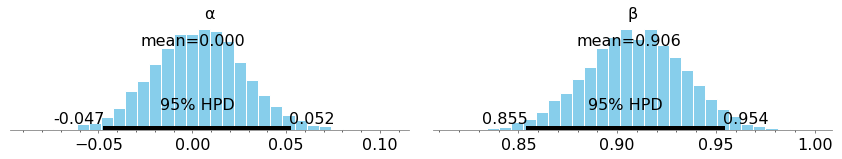

In [19]:
pm.plot_posterior(trace=trace_pooled_informative, varnames=['α', 'β']);

In [178]:
ppc = pm.sample_posterior_predictive(trace_pooled_informative,
                                     model=m_pooled_informative)['log_chl_s']
ppc_mean = ppc.mean(axis=0)
hpd = pm.hpd(ppc)

100%|██████████| 8000/8000 [00:04<00:00, 1718.59it/s]


In [23]:
with m_unpooled_informative:
    trace_unpooled_informative = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:21<00:00, 553.54draws/s]


In [64]:
with m_partially_pooled_informative:
    trace_partially_pooled_informative = pm.sample(2000, tune=10000, chains=4,
                                                   nuts_kwargs=(dict(target_accept=0.95)
                                                               ))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, β, α, hyp_β_sd, hyp_β_mean, hyp_α_sd, hyp_α_mean]
Sampling 4 chains: 100%|██████████| 48000/48000 [04:33<00:00, 175.61draws/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


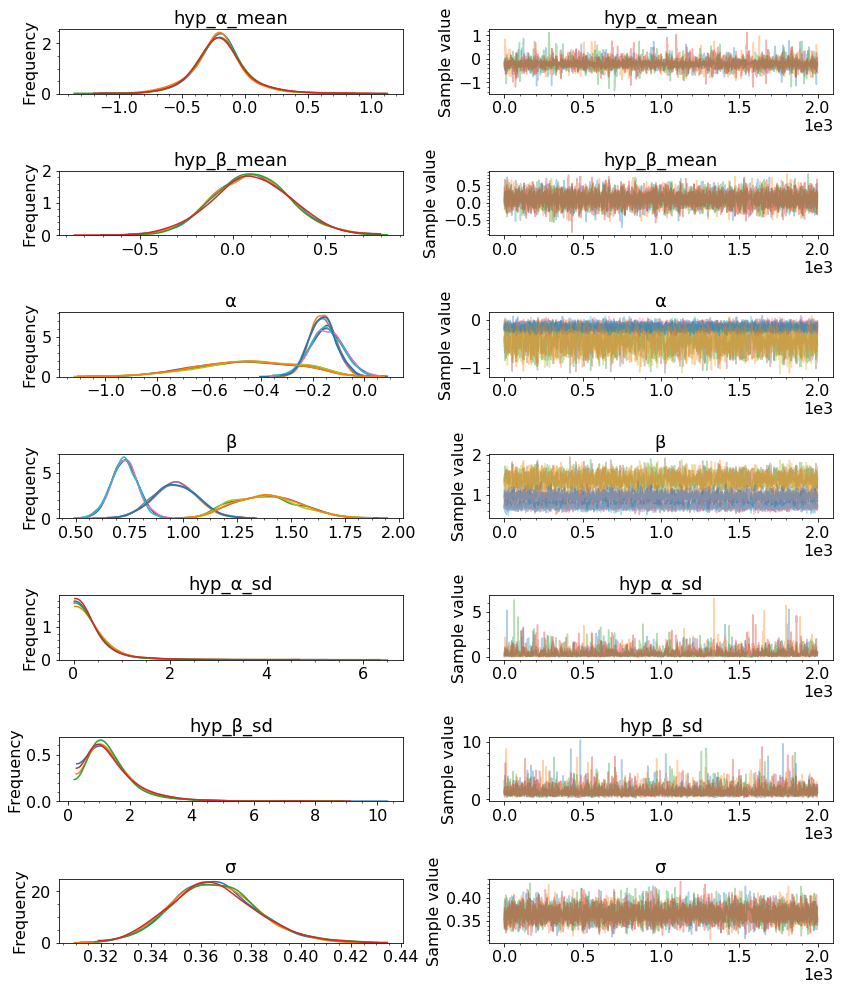

In [48]:
pm.traceplot(trace_partially_pooled_informative);

In [49]:
pm.summary(trace_partially_pooled_informative)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
hyp_α_mean,-0.201644,0.216518,0.003518,-0.631844,0.268982,3494.509349,1.000228
hyp_β_mean,0.100621,0.207639,0.002433,-0.291595,0.529106,6007.777350,0.999773
α__0,-0.146657,0.064801,0.001067,-0.271293,-0.016862,4504.619460,1.000469
α__1,-0.162152,0.051262,0.000610,-0.256866,-0.055456,5589.232658,0.999847
α__2,-0.452496,0.192989,0.003897,-0.823171,-0.111624,2364.878303,1.001426
β__0,0.725385,0.061181,0.000977,0.610690,0.855313,4626.498766,1.000572
β__1,0.962685,0.101201,0.001403,0.755933,1.151075,5228.713734,1.000132
β__2,1.386264,0.150314,0.002924,1.111722,1.670759,2468.061763,1.001179
hyp_α_sd,0.413403,0.453238,0.007910,0.014503,1.218962,2749.187918,1.000600
hyp_β_sd,1.441095,0.888674,0.014214,0.342415,3.099802,4226.740245,1.000184


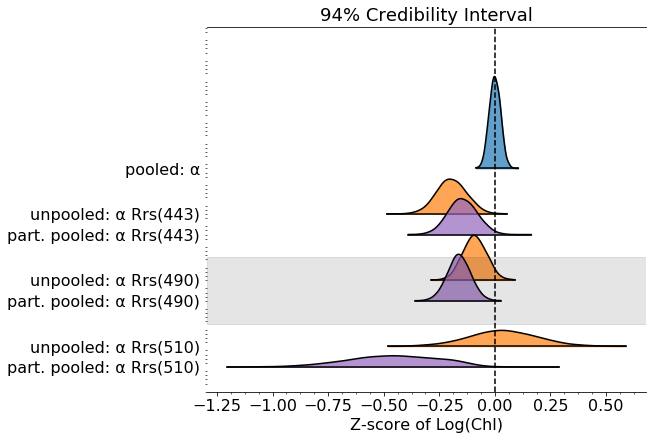

In [78]:
f, axs = ar.plot_forest([trace_pooled_informative,
                         trace_unpooled_informative,
                         trace_partially_pooled_informative],
                        model_names= ['pooled', 'unpooled', 'part. pooled'],
                        var_names=['α'], combined=True,
                        kind='ridgeplot', ridgeplot_overlap=5, ridgeplot_alpha=0.7,
                        colors=['C0', 'C1', 'C4'], figsize=(9,6))
new_labels = []
for txt in axs[0].yaxis.get_ticklabels():
    st = txt.get_text()
    if 'α 2' in st:
        st = st.replace('2', 'Rrs(510)')
    elif 'α 1' in st:
        st = st.replace('1', 'Rrs(490)')
    elif 'α 0' in st:
        st = st.replace('0', 'Rrs(443)')
    new_labels.append(st)
axs[0].yaxis.set_ticklabels(new_labels)
axs[0].axvline(ls='--', color='k')
axs[0].set_title('94% Credibility Interval')
axs[0].set_xlabel('Z-score of Log(Chl)')
f.savefig('./resources/forest_intercept.png', dpi=300);

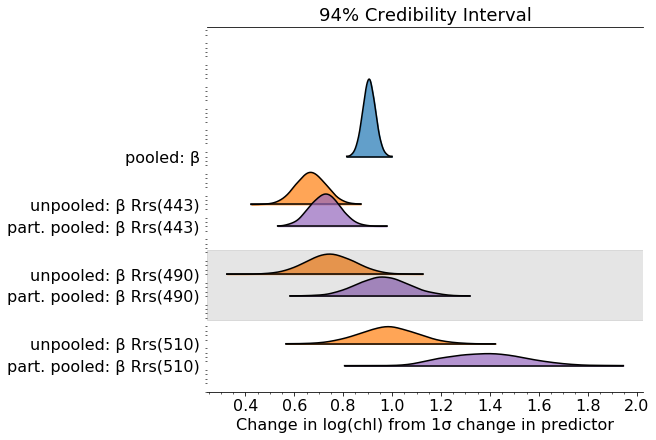

In [77]:
f, axs = ar.plot_forest([trace_pooled_informative,
                         trace_unpooled_informative,
                         trace_partially_pooled_informative],
                        model_names= ['pooled', 'unpooled', 'part. pooled'],
                        var_names=['β'], combined=True,
                        kind='ridgeplot', ridgeplot_overlap=4, ridgeplot_alpha=0.7,
                        colors=['C0', 'C1', 'C4'], figsize=(9,6))
new_labels = []
for txt in axs[0].yaxis.get_ticklabels():
    st = txt.get_text()
    if 'β 2' in st:
        st = st.replace('2', 'Rrs(510)')
    elif 'β 1' in st:
        st = st.replace('1', 'Rrs(490)')
    elif 'β 0' in st:
        st = st.replace('0', 'Rrs(443)')
    new_labels.append(st)
axs[0].yaxis.set_ticklabels(new_labels)
#axs[0].axvline(ls='--', color='k')
axs[0].set_title('94% Credibility Interval')
axs[0].set_xlabel('Change in log(chl) from 1σ change in predictor')
f.savefig('./resources/forest_slopes.png', dpi=300)

<table>
    <td>
        <img src='./resources/forest_intercept.png?:1' width=500/>
    </td>
    <td>
        <img src='./resources/forest_slopes.png?:1' width=500/>
    </td>
</table>

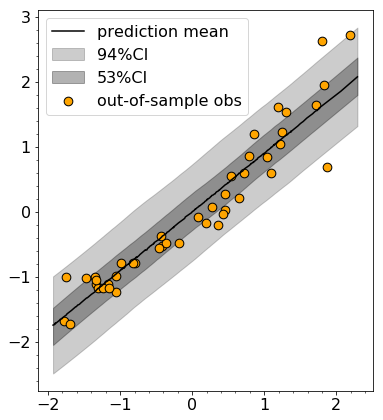

In [180]:
x_idx = X_train_s.green2MaxBlue_s.argsort()

f, ax = pl.subplots(figsize=(6, 7))
ax.plot(X_train_s.green2MaxBlue_s.values[x_idx],ppc_mean[x_idx], color='k',
        label='prediction mean')
ar.plot_hpd(X_train_s.green2MaxBlue_s, ppc, fill_kwargs=dict(alpha=0.2, 
                                                             color='k',
                                                             label='94%CI'),
            credible_interval=0.94, ax=ax)
ar.plot_hpd(X_train_s.green2MaxBlue_s, ppc, fill_kwargs=dict(alpha=0.3, 
                                                             color='k',
                                                             label='53%CI'),
            credible_interval=0.53, ax=ax)
ax.scatter(X_test_s.green2MaxBlue_s.values, y_test_s, color='orange', edgecolor='k',
           label='out-of-sample obs', s=75)
ax.legend(loc='upper left')
f.savefig('./resources/ppc_informative.png', dpi=300)

/Users/erdemk/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pandas/core/dtypes/dtypes.py:458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


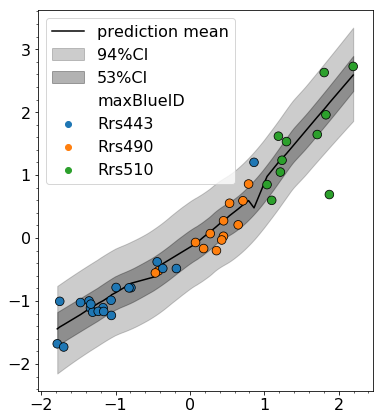

In [175]:
β_post_part_pld_inf = trace_partially_pooled_informative.get_values('β')
α_post_part_pld_inf = trace_partially_pooled_informative.get_values('α')
σ_post_part_pld_inf = trace_partially_pooled_informative.get_values('σ').reshape(-1, 1)

μ_post_1 = α_post_part_pld_inf[:,X_test_s.maxBlueIdx]

μ_post_2 = β_post_part_pld_inf[:, X_test_s.maxBlueIdx] * X_test_s.green2MaxBlue_s.values.reshape(1, -1)

μ_post = μ_post_1 + μ_post_2

μ_post_means = μ_post.mean(axis=0)
ppc_part_pld = norm.rvs(μ_post, scale=σ_post_part_pld_inf)

ppc_mean_part_pld = ppc_part_pld.mean(axis=0)

cols = ['C0', 'C1', 'C2']
col_vec = [cols[i] for i in X_test_s.maxBlueIdx.values]

f, ax = pl.subplots(figsize=(6, 7))
x_idx = X_test_s.green2MaxBlue_s.argsort()
ax.plot(X_test_s.green2MaxBlue_s.values[x_idx],ppc_mean_part_pld[x_idx],
        label='prediction mean', color='k', zorder=0)
ar.plot_hpd(X_test_s.green2MaxBlue_s, ppc_part_pld,
            fill_kwargs=dict(alpha=0.2, color='k', label='94%CI'),
            credible_interval=0.94, ax=ax)
ar.plot_hpd(X_test_s.green2MaxBlue_s, ppc_part_pld,
            fill_kwargs=dict(alpha=0.3, color='k', label='53%CI'),
            credible_interval=0.53, ax=ax,)
#ax.scatter(X_test_s.green2MaxBlue_s.values, y_test_s, color= col_vec, edgecolor='k',
           #label=['out-of-sample obs1', '2', '3'], s=50)#
sb.scatterplot(X_test_s.green2MaxBlue_s.values.flat, y_test_s.values.flat,ax=ax,
               hue=X_test_s.maxBlueID, hue_order=['Rrs443', 'Rrs490', 'Rrs510'],
              palette=cols, zorder=3, edgecolor='k', s=75,
              )
l = ax.legend();
ax.set_label(r'$log_{10}\left(\frac{green}{max(blue)}$')
f.savefig('./resources/ppc_part_pld_inf.png', dpi=300)

<table>
    <td>
        <img src="./resources/ppc_informative.png?:2"  width=500 />
    </td>
    <td>
        <img src="./resources/ppc_part_pld_inf.png?:0" width=500 />
    </td>
</table>

In [198]:
model_dict = dict(models=dict(part_pooled_inf=m_partially_pooled_informative,
                              unpooled_inf=m_unpooled_informative,
                              pooled_inf=m_pooled_informative), 
                  trace=dict(part_pooled_inf=trace_partially_pooled_informative,
                             unpooled_inf=trace_unpooled_informative, 
                             pooled_inf=trace_pooled_informative))

In [199]:
with open('./resources/models_dict.pkl', 'wb') as fb:
    pickle.dump(model_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
df_loo = pm.compare({m_pooled_informative: trace_pooled_informative,
                     m_unpooled_informative: trace_unpooled_informative,
                     m_partially_pooled_informative: trace_partially_pooled_informative},
                    ic='LOO')

In [82]:
df_loo[['LOO', 'pLOO', 'dLOO', 'weight']]

,LOO,pLOO,dLOO,weight
part. pooled inf.,210.75,7.66,0,0.86
unpooled inf,228.16,7.22,17.4,0
pooled inf.,244.96,3.05,34.21,0.14


[Back to Contents](#TOP)

<a id=conclusion></a>
Programming
1. ~~A Quick Primer~~
2. ~~Model Development: Approximating the Data Generating Process~~
3. ~~Priors for Context-Aware Models~~
4. ~~Fitting Data, Model Evaluation, Model Comparison~~
5. <font color=red>Conclusion</font>

### 5. Conclusion


* Open Source Probabilistic Programming Libraries 
* Inclusion of background information through priors:
    * provides modeling context
    * transparency in assumptions $\rightarrow$ models become debatable
* Generative model enables simulation before and after data collection and fitting
* Built-in principled uncertainty estimation via probabilistic sampling
* Natural fit for use with Information Theory
    * prior selection $\rightarrow$ maximum entropy
    * model evaluation
    * model comparison

#### Further Reading/Tinkering:
<br>

<table>
    <tr>
        <td>
            <img src='./resources/books/StatRethink.png' width=200/>
        </td>
        <td></td>
        <td>
            <img src='./resources/books/BayesPyth.png' width=200/>
        </td>
        <td></td>
        <td>
            <img src='./resources/books/Hackers.png' width=200/>
        </td>
    </tr>
</table>

#### Further Reading/Tinkering:
<br>

<table>
    <tr>
        <td>
            <img src='./resources/logos/pymc3logo.png' width=200/>
        </td>
        <td>
        </td>
        <td>
            <img src='./resources/logos/Stan_logo.png' width=200/>
        </td>
        <td>
        </td>
        <td>
            <img src='./resources/logos/Pyro_logo.png' width=200/>
        </td>
        <td>
        </td>
        <td>
            <img src='./resources/logos/edward_logo.png' width=200/>
        </td>
    </tr>
</table>

### Github link to underlying notebooks: 

* http://tinyurl.com/yytsbufv
* [Notebook 1: Reproducible Pre-Processing Pipeline](./BUSAN2019-1-PreprocessingPipeline.ipynb)
* Notebook 2: Probabilistic Programming Workflow
* erdem.m.karakoylu@nasa.gov